In [2]:
import scipy.optimize as op
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pickle
from scipy.signal import lombscargle
from george import kernels
import george

In [3]:
with open("assignment2_gp.pkl", "rb") as fp:
  data = pickle.load(fp)

In [4]:
data

{'t': array([1182.75677574, 1182.77720982, 1182.8180783 , ..., 1272.99543299,
        1273.01586731, 1273.05673626]),
 'y': array([-0.59697205, -0.88745168, -0.66566005, ...,  1.31965855,
         1.46644973,  2.33382297]),
 'yerr': array([0.17157656, 0.17169682, 0.17166864, ..., 0.17088509, 0.17089593,
        0.1709056 ])}

In [5]:
t = data['t']
y = data['y']
y_err = data['yerr']

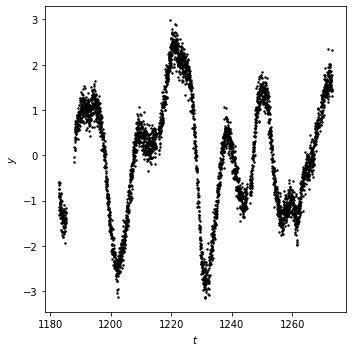

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
    
ax.scatter(t, y, c="k", s=2)

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$y$")
    
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(7))
    
fig.tight_layout();

In [7]:
max_dt = np.max(t) - np.min(t)
max_f = 1/max_dt


In [8]:
f = np.linspace(0.001, 2, 1000)

In [9]:
pgram = lombscargle(t, y, f)

Text(0, 0.5, 'Power')

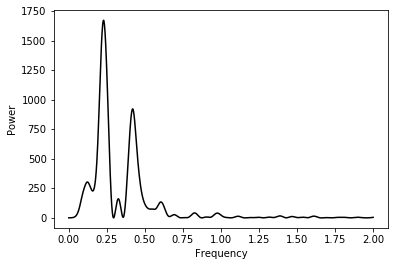

In [10]:
plt.plot(f, pgram, c='k');
plt.xlabel('Frequency')
plt.ylabel('Power')

In [11]:
peak_i = np.where(np.r_[True, pgram[1:] > pgram[:-1]] & np.r_[pgram[:-1] > pgram[1:], True])[0]

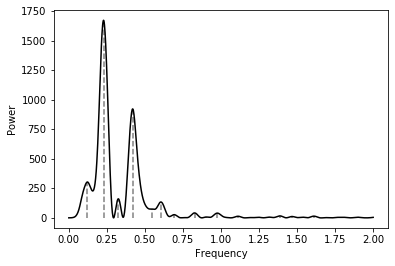

In [12]:
peak_f = f[peak_i]
peak_p = pgram[peak_i]
plt.plot(f, pgram, c='k');
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.vlines(peak_f, 0, peak_p, linestyle='--', colors='gray');

In [11]:
# get peaks with >100 power
peak_i = peak_i[np.where(peak_p>100)]

NameError: name 'peak_i' is not defined

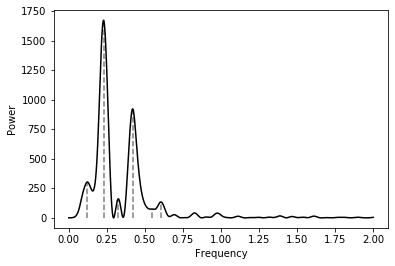

In [14]:
peak_f = f[peak_i]
peak_p = pgram[peak_i]
plt.plot(f, pgram, c='k');
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.vlines(peak_f, 0, peak_p, linestyle='--', colors='gray');

In [27]:
periods = 2*np.pi / peak_f

In [12]:
print('Frequency: \t Power: \t Periods:')
for freq, power, T in zip(peak_f, peak_p, periods):
    print(f'{freq:.3}\t \t {int(power)} \t \t {int(T)}')

Frequency: 	 Power: 	 Periods:


NameError: name 'peak_f' is not defined

## Part 2

In [37]:
periods[3]

14.916982435074127

Error is gaussian distributed, with periodicity described above.
Therefore 

In [73]:
k1 = kernels.ExpSine2Kernel(gamma=1, log_period=np.log(periods[1]))
k2 = kernels.ExpSine2Kernel(gamma=1, log_period=np.log(periods[3]))

kernel = k1 + k2
kernel *= 1 * kernels.ExpSquaredKernel(1000)

gp = george.GP(kernel)
gp.compute(t, y_err)

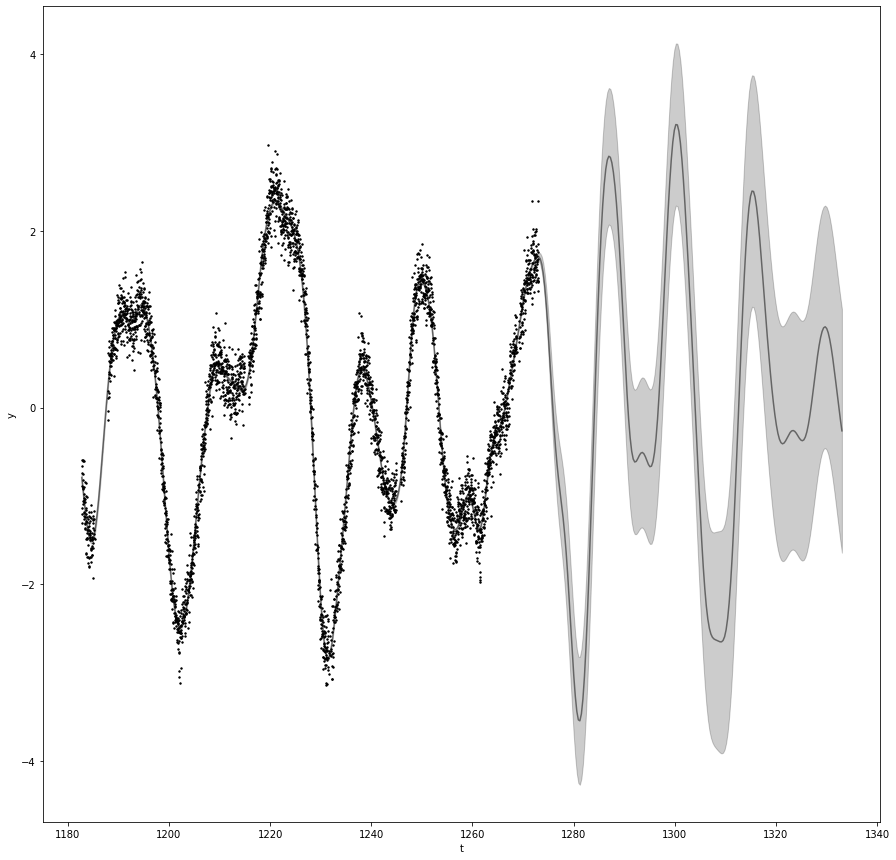

In [74]:
t_min = np.min(t)
t_max = np.max(t)
t_pred = np.linspace(t_min, t_max + 60, 500)
pred, pred_var = gp.predict(y, t_pred, return_var=True)


plt.figure(figsize=(15, 15))
plt.fill_between(t_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(t_pred, pred, "k", lw=1.5, alpha=0.5)
plt.scatter(t, y, c="k", s=2)
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
# plt.xlim(1180, 1200)
# plt.ylim(-1.45, 1.45)
plt.xlabel("t")
plt.ylabel("y");

In [64]:
print(f"Initial ln-likelihood: {gp.log_likelihood(y):.2f}")

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)


# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(f"Final ln-likelihood: {gp.log_likelihood(y):.2f}")

Initial ln-likelihood: 262.37
643.0846441331


In [72]:
print(f"Final ln-likelihood: {gp.log_likelihood(y):.2f}")

Final ln-likelihood: 643.08


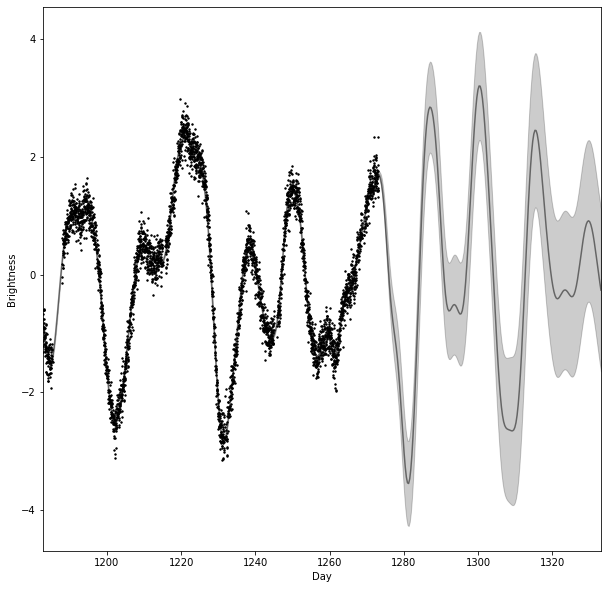

In [85]:
t_min = np.min(t)
t_max = np.max(t)
t_pred = np.linspace(t_min, t_max + 60, 500)
mu, var = gp.predict(y, t_pred, return_var=True)


plt.figure(figsize=(10, 10))
plt.fill_between(t_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(t_pred, pred, "k", lw=1.5, alpha=0.5)
plt.scatter(t, y, c="k", s=2)
plt.xlim(t_min, t_max + 60)
plt.xlabel("Day")
plt.ylabel("Brightness");
plt.savefig("Gaussian_process_opt.png", dpi=300)